In [3]:
# setting up all of the packages
!pip install -q optuna

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
# import torch
# import torch.nn as nn
import optuna
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
# from utils import * 
from sklearn.metrics import mean_squared_error, r2_score
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

# raster and dataframe handling packages
import rasterio
import rioxarray as rio

# stats packages
from scipy.stats import ks_2samp
from sklearn.preprocessing import StandardScaler

# print(os.getcwd())
# custom functions from class LEAP env.
# from utils import * 

# plotting parameters
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preparing our predictor and predictand data
predictor: (X, TerraClim climate variables), predictant: (Y, MODIS LAI) data

In [51]:
train_path = "/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/lagFeatures/"
test_path  = "/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/lagFeatures/"

train_files = sorted(glob.glob(os.path.join(train_path, "x_train_lags_*.csv")))
test_files  = sorted(glob.glob(os.path.join(test_path,  "x_test_lags_*.csv")))

print(train_files)

def load_and_merge_lags(file_list):
    dfs = []

    for f in file_list:
        df = pd.read_csv(f, parse_dates=["time"])
        
        # Set index for safe merging
        df = df.set_index(["time", "lat", "lon"])
        
        dfs.append(df)

    # Inner join ensures perfect alignment
    merged = pd.concat(dfs, axis=1, join="inner")

    return merged

predictors = ["tmmx", "tmmx_lag16", "tmmx_lag14", 
              "tmmn_lag15", "tmmn_lag5", "tmmn_lag6",
              "pr", "pr_lag3", "pr_lag12",
              "pdsi", "pdsi_lag18", "pdsi_lag14",
              "def_lag7", "def_lag8", "def_lag6",
              "vpd_lag16", "vpd_lag17", "vpd_lag6",
              "soil_lag5", "soil_lag6", "soil_lag18",
             ]

X_train = load_and_merge_lags(train_files)[predictors]
X_test  = load_and_merge_lags(test_files)[predictors]

print(X_train.shape)
print(X_test.shape)

print(X_train.index.names)
print(X_train.columns)

print(X_train.head())

['/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/lagFeatures/x_train_lags_def.csv', '/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/lagFeatures/x_train_lags_pdsi.csv', '/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/lagFeatures/x_train_lags_pr.csv', '/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/lagFeatures/x_train_lags_soil.csv', '/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/lagFeatures/x_train_lags_tmmn.csv', '/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/lagFeatures/x_train_lags_tmmx.csv', '/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/lagFeatures/x_train_lags_vpd.csv']
(331506, 21)
(15786, 21)
['time', 'lat', 'lon']
Index(['tmmx', 'tmmx_lag16', 'tmmx_lag14', 'tmmn_lag15', 'tmmn_lag5',
       'tmmn_lag6', 'pr', 'pr_lag3', 'pr_lag12', 'pdsi', 'pdsi_lag18',
       'pdsi_lag14', 'def_lag7', 'def_lag8', 'def_lag6', 'vpd_lag16',
       'vpd_lag17', 'vpd_lag6', 'soil_lag5', 'soil_lag6', 'soil_lag18'],
      dtype='object')
                                   tmmx  tmmx_lag16  tmmx_lag14  tmmn_lag15

In [ ]:
y_train_file = os.path.join(train_path, "y_train_lai.csv")
y_test_file  = os.path.join(test_path,  "y_test_lai.csv")

# Load y data
y_train = pd.read_csv(y_train_file, parse_dates=["time"]).set_index(["time", "lat", "lon"])
y_test  = pd.read_csv(y_test_file,  parse_dates=["time"]).set_index(["time", "lat", "lon"])

# Align with merged X (inner join ensures exact matching rows)
y_train = y_train.loc[X_train.index]
y_test  = y_test.loc[X_test.index]

print(y_train.shape)
print(y_test.shape)

print(y_train.head())

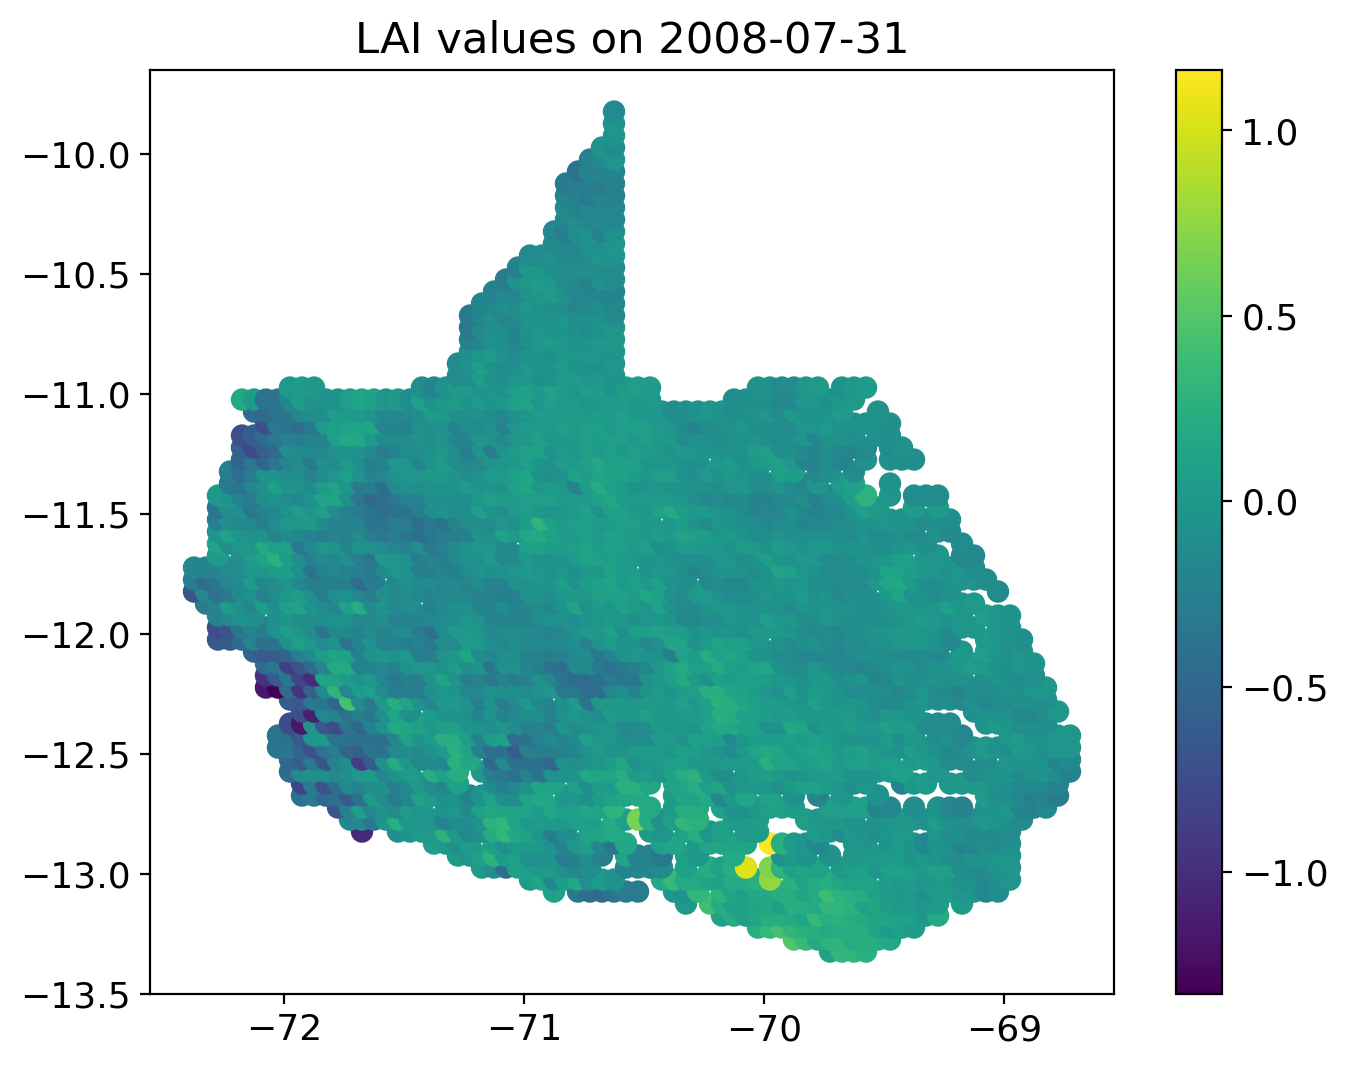

In [36]:
# Pick a date to map
date_to_plot = "2008-07-31"

# Select rows for that time
df_map = y_train.loc[date_to_plot]

# Reset index to get lat/lon as columns
df_map = df_map.reset_index()

gdf = gpd.GeoDataFrame(
    df_map,
    geometry=gpd.points_from_xy(df_map['lon'], df_map['lat']),
)


fig, ax = plt.subplots(figsize=(8,6))
gdf.plot(column="lai", ax=ax, legend=True, cmap="viridis", markersize=50)
ax.set_title(f"LAI values on {date_to_plot}")
plt.show()

In [8]:
# # establish path and open our merged and masked climate and LAI data as an array
# # path = "/home/jovyan/large_files/climLai_masked_v3.nc"
# path = "/home/jovyan/large_files/climLai_masked_anom.nc"
# ds_combined = xr.open_dataset(path)

In [31]:
# # Count NaNs per variable, these should all match!
# for var in ds_combined.data_vars:
#     print(var, ds_combined[var].isnull().sum().item())

In [37]:
# # take a look and map at the ds_combined dataset, this should only cover the political extent of Madre de Dios
# print(ds_combined)
# ds_combined.tmmn.isel(time=210).plot(figsize=(8,6))

In [38]:
# ds = ds_combined   # your dataset

# vars_to_plot = ["tmmx","tmmn","pr","pdsi","def","vpd","soil","lai"]

# fig, axes = plt.subplots(2, 4, figsize=(18, 9))
# axes = axes.ravel()

# for ax, var in zip(axes, vars_to_plot):
#     data = ds[var].values.flatten()
#     data = data[~np.isnan(data)]
#     ax.hist(data, bins=50)
#     ax.set_title(var)

# plt.tight_layout()
# plt.show()

In [39]:
# # the data array has 3 dimensions (time, lat, lon). Stack the coordinate values to go from 3d to 2d.
# ds_stacked = ds_combined.stack(stacked=("lat", "lon"))

In [40]:
# # convert to data frame for later processing. Time, lat, lon become indexes.
# df_combined = ds_stacked.to_dataframe().dropna()
# print(df_combined)

In [41]:
# # from dataframe generate the x_df (ONLY climate predictor variables, drop the lai column)
# x_df = df_combined.drop(columns=["lai","spatial_ref"])

# # look at x_df, make sure it looks ok!
# x_df.head()

In [42]:
# # from dataframe generate y_df (ONLY lai)
# y_df = df_combined.drop(columns=["spatial_ref",
#                                  "tmmx",
#                                  "tmmn",
#                                  "pr",
#                                  "pdsi",
#                                  "def",
#                                  "vpd",
#                                  "soil",
#                                  "month"])

# # look at y_df, make sure it looks ok!
# y_df.head()

## Split our data into training, validation and testing and normalize
Look at the entire time sequence of our data: 19 years, 12 months per year
(19yrs x 12months) = 228 time steps

We want the last two years to be our testing dataset: 2019 and 2020
Therefore, the first 17 tears are our training and validation data
Of this, 80% must be training (14 years), 20% must be validation (3 years)

So the final break-down is:
Training: 2002-2015 (14yrs x 12months = 168 ts)
Validation: 2016-2018 (3yrs x 12months = 36 ts)
Testing: 2019-2020 (2yrs x 12months = 24 ts)

In [43]:
# train_yr_start = 2007
# test_yr_start = 2019
# test_yr_end = 2020

In [26]:
# # look at the entire time sequence of our data
# first_time = x_df.index.get_level_values("time")[0]
# last_time  = x_df.index.get_level_values("time")[-1]

# print('time 0 =', first_time)
# print('time last =', last_time)

time 0 = 2002-01-31 00:00:00
time last = 2020-12-31 00:00:00


In [44]:
# # -----------------------------
# # 1. Define time boundaries
# # -----------------------------
# train_start = f"{train_yr_start}-01-31"
# test_start  = f"{test_yr_start}-01-31"
# test_end    = f"{test_yr_end+1}-01-31"   # exclusive

# times = x_df.index.get_level_values("time")

# # -----------------------------
# # 2. Split data by time
# # -----------------------------
# x_df_train = x_df.loc[times < test_start]
# y_df_train = y_df.loc[times < test_start]

# x_df_test  = x_df.loc[(times >= test_start) & (times < test_end)]
# y_df_test  = y_df.loc[(times >= test_start) & (times < test_end)]

# # -----------------------------
# # 3. Remove noisy early year (2002)
# # -----------------------------
# x_df_train = x_df_train.loc[x_df_train.index.get_level_values("time") >= train_start]
# y_df_train = y_df_train.loc[y_df_train.index.get_level_values("time") >= train_start]

# # -----------------------------
# # 4. Min–max normalize (train → test)
# # -----------------------------
# feature_cols = ["tmmx", "tmmn", "pr", "pdsi", "def", "vpd", "soil"]

# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler.fit(x_df_train[feature_cols])

# x_df_train[feature_cols] = scaler.transform(x_df_train[feature_cols])
# x_df_test[feature_cols]  = scaler.transform(x_df_test[feature_cols])

# # -----------------------------
# # 5. Sanity checks
# # -----------------------------
# print("train:", x_df_train.index.get_level_values("time")[0],
#       "→", x_df_train.index.get_level_values("time")[-1])

# print("test :", x_df_test.index.get_level_values("time")[0],
#       "→", x_df_test.index.get_level_values("time")[-1])


In [45]:
# feature_cols = ["tmmx","tmmn","pr","pdsi","def","vpd","soil"]

# # let's check the normalizaton
# # look at some summary statistics to check the normalization
# train_stats = x_df_train[feature_cols].agg(['mean','std']).T
# test_stats = x_df_test[feature_cols].agg(['mean','std']).T

# # let's check our standardization
# print("Training data\n", train_stats)
# print("Testing data\n", test_stats)

In [46]:
# # test to make sure the splits worked:
# print('shape x_df_train', x_df_train.shape)
# # print('shape x_df_valid', x_df_valid.shape)
# print('shape x_df_test', x_df_test.shape)

# print('shape y_df_train', y_df_train.shape)
# # print('shape y_df_valid', y_df_valid.shape)
# print('shape y_df_test', y_df_test.shape)

In [18]:
# # look at some summary statistics to check the normalization
# train_stats = x_df_train[feature_cols].agg(['mean','std']).T
# # valid_stats = x_df_valid[feature_cols].agg(['mean','std']).T
# test_stats = x_df_test[feature_cols].agg(['mean','std']).T

# # let's check our standardization
# print("Training data\n", train_stats)
# # print("Validation data\n", valid_stats)
# print("Testing data\n", test_stats)

In [47]:
# print(x_df_train)
# print(x_df_test)
# print(y_df_train)
# print(y_df_test)

In [48]:
# def create_lags(df, feature_cols, n_lags):
#     """
#     df: DataFrame with multi-index (time, lat, lon)
#     feature_cols: list of columns to create lags for
#     n_lags: number of lag steps
#     """
#     lagged_dfs = []

#     # Group by spatial location
#     for (lat, lon), group in df.groupby(level=[1, 2]):
#         group_lags = group[feature_cols].copy()
#         for col in feature_cols:
#             for lag in range(1, n_lags+1):
#                 group_lags[f"{col}_lag{lag}"] = group[col].shift(lag)
#         lagged_dfs.append(group_lags)

#     # Concatenate all
#     lagged_df = pd.concat(lagged_dfs)
#     return lagged_df

In [132]:
# # feature_cols = ["tmmx","tmmn","pr","pdsi","def","vpd","soil","month"]
# feat = 'soil'
# train_lags = create_lags(x_df_train, feature_cols = [feat], n_lags=18)
# test_lags = create_lags(x_df_test, feature_cols = [feat], n_lags=18)

In [49]:
# train_lags_clean = train_lags.dropna()
# test_lags_clean = test_lags.dropna()
# y_train_lags_clean = y_df_train.loc[train_lags_clean.index]["lai"]
# y_test = y_df_test.loc[test_lags_clean.index]["lai"]

# print(train_lags_clean)
# print(len(train_lags_clean))
# print(len(y_train_lags_clean))
# print(y_test)

# test_index = test_lags_clean.index
# print(test_index)

In [134]:
# import os

# # Base path where you want to save
# export_path = "/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/lagFeatures/"
# # os.makedirs(export_path, exist_ok=True)  # create folder if it doesn't exist

# # Dynamic filename including the feature name
# train_file = os.path.join(export_path, f"x_train_lags_{feat}.csv")
# test_file  = os.path.join(export_path, f"x_test_lags_{feat}.csv")
# # y_train_file = os.path.join(export_path, f"y_train_lags_{feat}.csv")
# # y_test_file  = os.path.join(export_path, f"y_test_lags_{feat}.csv")

# # Export to CSV
# train_lags_clean.to_csv(train_file)
# test_lags_clean.to_csv(test_file)
# # y_train_lags_clean.to_csv(y_train_file)
# # y_test.to_csv(y_test_file)

# print(f"Saved train lags: {train_file}")
# print(f"Saved test lags: {test_file}")
# # print(train_lags_clean)

Saved train lags: /home/jovyan/MLEAEEE4000-DroughtAmazon2/data/lagFeatures/x_train_lags_soil.csv
Saved test lags: /home/jovyan/MLEAEEE4000-DroughtAmazon2/data/lagFeatures/x_test_lags_soil.csv


In [55]:
n_estimators      = 100    # Number of trees in random forest
min_samples_split = 10     # Minimum number of samples required to split a node
min_samples_leaf  = 4      # Minimum number of samples required at each leaf node
max_features      = None   # Number of features to consider at every split: 'sqrt', 'log2', or None.
                           # None: max_features=n_feature
max_depth         = None     # Maximum number of levels in tree
bootstrap         = True   # Method of selecting samples for training each tree

reg0 = RandomForestRegressor(n_estimators=n_estimators,
                             min_samples_split=min_samples_split,
                             min_samples_leaf=min_samples_leaf,
                             max_features=max_features,
                             max_depth=max_depth,
                             bootstrap=bootstrap)

rf_tas = reg0.fit(X_train,y_train['lai'])

In [56]:
import os
import joblib

# export and SAVE model
model_path = f"/home/jovyan/MLEAEEE4000-DroughtAmazon2/model_outputs/RF/"
os.makedirs(model_path, exist_ok=True)

joblib.dump(
    rf_tas,
    os.path.join(
        model_path,
        f"rf_yr"
        f"{train_yr_start % 100}"
        f"{test_yr_start % 100}{test_yr_end % 100}.joblib"
    )
)

['/home/jovyan/MLEAEEE4000-DroughtAmazon2/model_outputs/RF/rf_yr71920.joblib']

In [65]:
model_path = f"/home/jovyan/MLEAEEE4000-DroughtAmazon2/model_outputs/RF/"

model_file = os.path.join(
    model_path,
    f"rf_yr"
        f"{train_yr_start % 100}"
        f"{test_yr_start % 100}{test_yr_end % 100}.joblib"
)

reg0 = joblib.load(model_file)

In [66]:
# reg0.feature_importances_

importances = pd.Series(
    reg0.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

print(importances)

print('something')

pr            0.072739
pr_lag12      0.071353
pr_lag3       0.063711
tmmx          0.059935
def_lag6      0.058720
tmmx_lag16    0.056718
def_lag7      0.052222
tmmx_lag14    0.051874
pdsi          0.049739
def_lag8      0.046795
soil_lag18    0.046276
pdsi_lag14    0.044528
tmmn_lag6     0.043529
tmmn_lag5     0.041045
vpd_lag17     0.039611
soil_lag5     0.037767
pdsi_lag18    0.037006
vpd_lag16     0.033759
vpd_lag6      0.031867
tmmn_lag15    0.030580
soil_lag6     0.030228
dtype: float64
something


In [67]:
# y_test_pre = rf_tas.predict(X_test)
# y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 96, 144)

# y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
#                                'latitude': X_test_xr.latitude.values, 
#                                'longitude': X_test_xr.longitude.values},
#                         data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre)))

In [68]:
y_pred_test = reg0.predict(X_test)
y_pred_test

array([-0.12989215,  0.25412536,  0.02584371, ...,  0.06592195,
        0.09485453, -0.19417041], shape=(15786,))

RMSE: 0.3119422695678472
MAE: 0.23178091326230602
R²: -0.27555744921457315


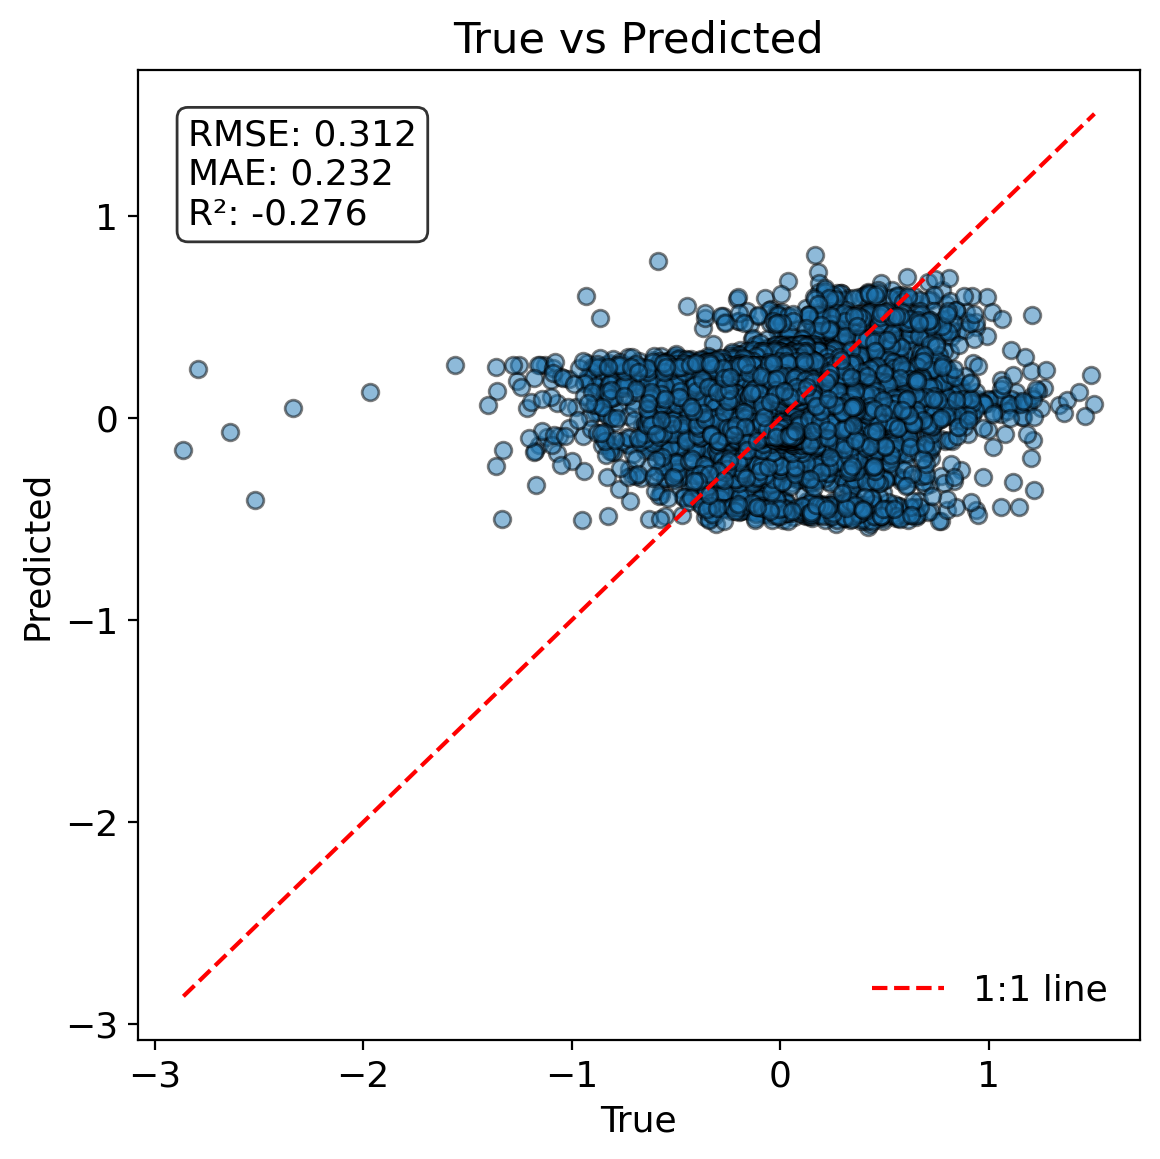

In [77]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure y_test and y_pred_test are 1D arrays
y_true = y_test.values.ravel()       # if DataFrame
y_pred = y_pred_test.ravel()         # if ndarray or DataFrame

# Compute metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)

# Scatter plot: True vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.5, color="tab:blue", edgecolor="k")

# 1:1 reference line
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="1:1 line")

plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("True vs Predicted")

# Annotate metrics
plt.text(0.05, 0.95,
         f"RMSE: {rmse:.3f}\nMAE: {mae:.3f}\nR²: {r2:.3f}",
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.legend()
plt.tight_layout()
plt.show()


In [64]:
test_index = X_test.index
print(test_index)

print(y_test.values.shape)
print(y_pred_test.shape)
print(y_test)
print(y_pred_test)

pred_df = pd.DataFrame({
    "time": test_index.get_level_values("time"),
    "lat":  test_index.get_level_values("lat"),
    "lon":  test_index.get_level_values("lon"),
    "true": y_test.values,
    "pred": y_pred_test
})

print(pred_df)

sw_lat, sw_lon = -12.504240199016463, -71.818702040585     # southwest corner  
ct_lat, ct_lon = -11.730855612666398, -70.79697352496      # central

lat0 = sw_lat
lon0 = sw_lon

def nearest_pixel(df, target_lat, target_lon):
    d = np.sqrt((df.lat - target_lat)**2 + (df.lon - target_lon)**2)
    idx = d.idxmin()
    return df.loc[idx, ['lat','lon']]

print("Nearest to SW:", nearest_pixel(pred_df, sw_lat, sw_lon))
print("Nearest to CT:", nearest_pixel(pred_df, ct_lat, ct_lon))

# Get nearest actual coords
sw_actual = nearest_pixel(pred_df, sw_lat, sw_lon)
ct_actual = nearest_pixel(pred_df, ct_lat, ct_lon)

pix_sw = pred_df[(pred_df.lat == sw_actual.lat) & (pred_df.lon == sw_actual.lon)]
pix_ct = pred_df[(pred_df.lat == ct_actual.lat) & (pred_df.lon == ct_actual.lon)]

# pixel_df = pred_df[(pred_df.lat == lat0) & (pred_df.lon == lon0)]

import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(pix_sw.time, pix_sw.true, label="True")
plt.plot(pix_sw.time, pix_sw.pred, label="Predicted")
plt.title(f"Time Series at ({lat0}, {lon0})")
plt.xlabel("Time")
plt.ylabel("LAI")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(12,4))
plt.plot(pix_ct.time, pix_ct.true, label="True")
plt.plot(pix_ct.time, pix_ct.pred, label="Predicted")
plt.title(f"Time Series at ({lat0}, {lon0})")
plt.xlabel("Time")
plt.ylabel("LAI")
plt.legend()
plt.grid(True)
plt.show()


mean_ts = pred_df.groupby("time")[["pred","true"]].mean()

plt.figure(figsize=(12,4))
plt.plot(mean_ts.index, mean_ts["true"], label="Mean True")
plt.plot(mean_ts.index, mean_ts["pred"], label="Mean Pred")
plt.legend()
plt.title("Mean LAI Over All Pixels")
plt.show()

MultiIndex([('2020-07-31', -13.325002,    -69.725),
            ('2020-08-31', -13.325002,    -69.725),
            ('2020-09-30', -13.325002,    -69.725),
            ('2020-10-31', -13.325002,    -69.725),
            ('2020-11-30', -13.325002,    -69.725),
            ('2020-12-31', -13.325002,    -69.725),
            ('2020-07-31', -13.325002, -69.674995),
            ('2020-08-31', -13.325002, -69.674995),
            ('2020-09-30', -13.325002, -69.674995),
            ('2020-10-31', -13.325002, -69.674995),
            ...
            ('2020-09-30',  -9.875002,    -70.625),
            ('2020-10-31',  -9.875002,    -70.625),
            ('2020-11-30',  -9.875002,    -70.625),
            ('2020-12-31',  -9.875002,    -70.625),
            ('2020-07-31',  -9.825002,    -70.625),
            ('2020-08-31',  -9.825002,    -70.625),
            ('2020-09-30',  -9.825002,    -70.625),
            ('2020-10-31',  -9.825002,    -70.625),
            ('2020-11-30',  -9.825002,    -70.62

ValueError: Per-column arrays must each be 1-dimensional

In [70]:
def compute_error_per_pixel(pred_df):

    def rmse(x, y):
        return np.sqrt(np.mean((x - y) ** 2))

    def mae(x, y):
        return np.mean(np.abs(x - y))

    def r2(x, y):
        # y = true, x = pred
        ss_res = np.sum((y - x) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        return np.nan if ss_tot == 0 else 1 - ss_res / ss_tot

    error_df = (
        pred_df
        .groupby(["lat", "lon"])
        .apply(lambda g: pd.Series({
            "rmse": rmse(g["pred"].values, g["true"].values),
            "mae": mae(g["pred"].values, g["true"].values),
            "r2": r2(g["pred"].values, g["true"].values)
        }))
        .reset_index()
    )

    return error_df

In [71]:
error_df = compute_error_per_pixel(pred_df)
print(error_df.head())

NameError: name 'pred_df' is not defined

In [118]:
def metric_to_raster(df, metric):
    lats = np.sort(df["lat"].unique())
    lons = np.sort(df["lon"].unique())

    raster = np.full((len(lats), len(lons)), np.nan, dtype=float)

    for _, row in df.iterrows():
        lat_idx = np.where(lats == row["lat"])[0][0]
        lon_idx = np.where(lons == row["lon"])[0][0]
        raster[lat_idx, lon_idx] = row[metric]

    return raster, lats, lons

In [119]:
rmse_raster, lats, lons = metric_to_raster(error_df, "rmse")
rmse_raster = np.flipud(rmse_raster)

mae_raster, _, _ = metric_to_raster(error_df, "mae")
mae_raster = np.flipud(mae_raster)

r2_raster, _, _ = metric_to_raster(error_df, "r2")
r2_raster = np.flipud(r2_raster)

rmse_lats = lats[::-1]

print(rmse_raster.shape)
print(mae_raster.shape)
print(r2_raster.shape)

(71, 74)
(71, 74)
(71, 74)


In [120]:
# # save your rmse raster to a geotiff
# import rasterio
# from rasterio.transform import from_origin

# def save_rmse_geotiff(filename, raster, lats, lons):
#     # Compute resolution
#     lat_res = abs(lats[1] - lats[0])
#     lon_res = abs(lons[1] - lons[0])
    
#     transform = from_origin(min(lons), max(lats), lon_res, lat_res)

#     with rasterio.open(
#         filename,
#         "w",
#         driver="GTiff",
#         height=raster.shape[0],
#         width=raster.shape[1],
#         count=1,
#         dtype=raster.dtype,
#         crs="EPSG:4326",
#         transform=transform,
#     ) as dst:
#         dst.write(raster, 1)

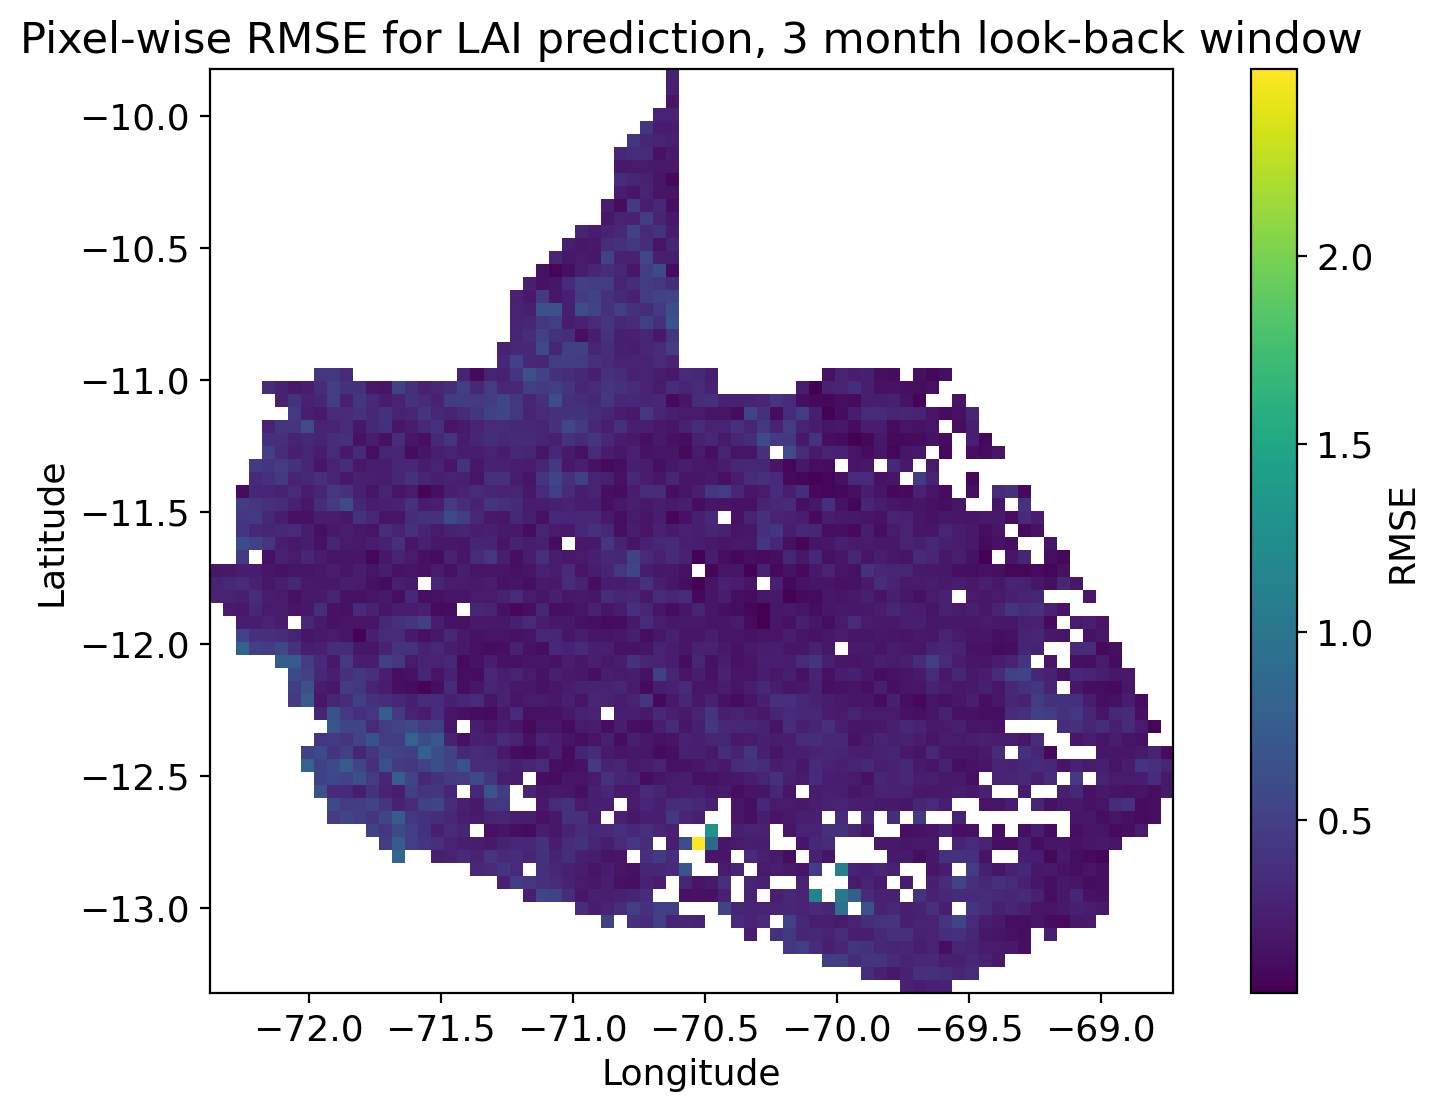

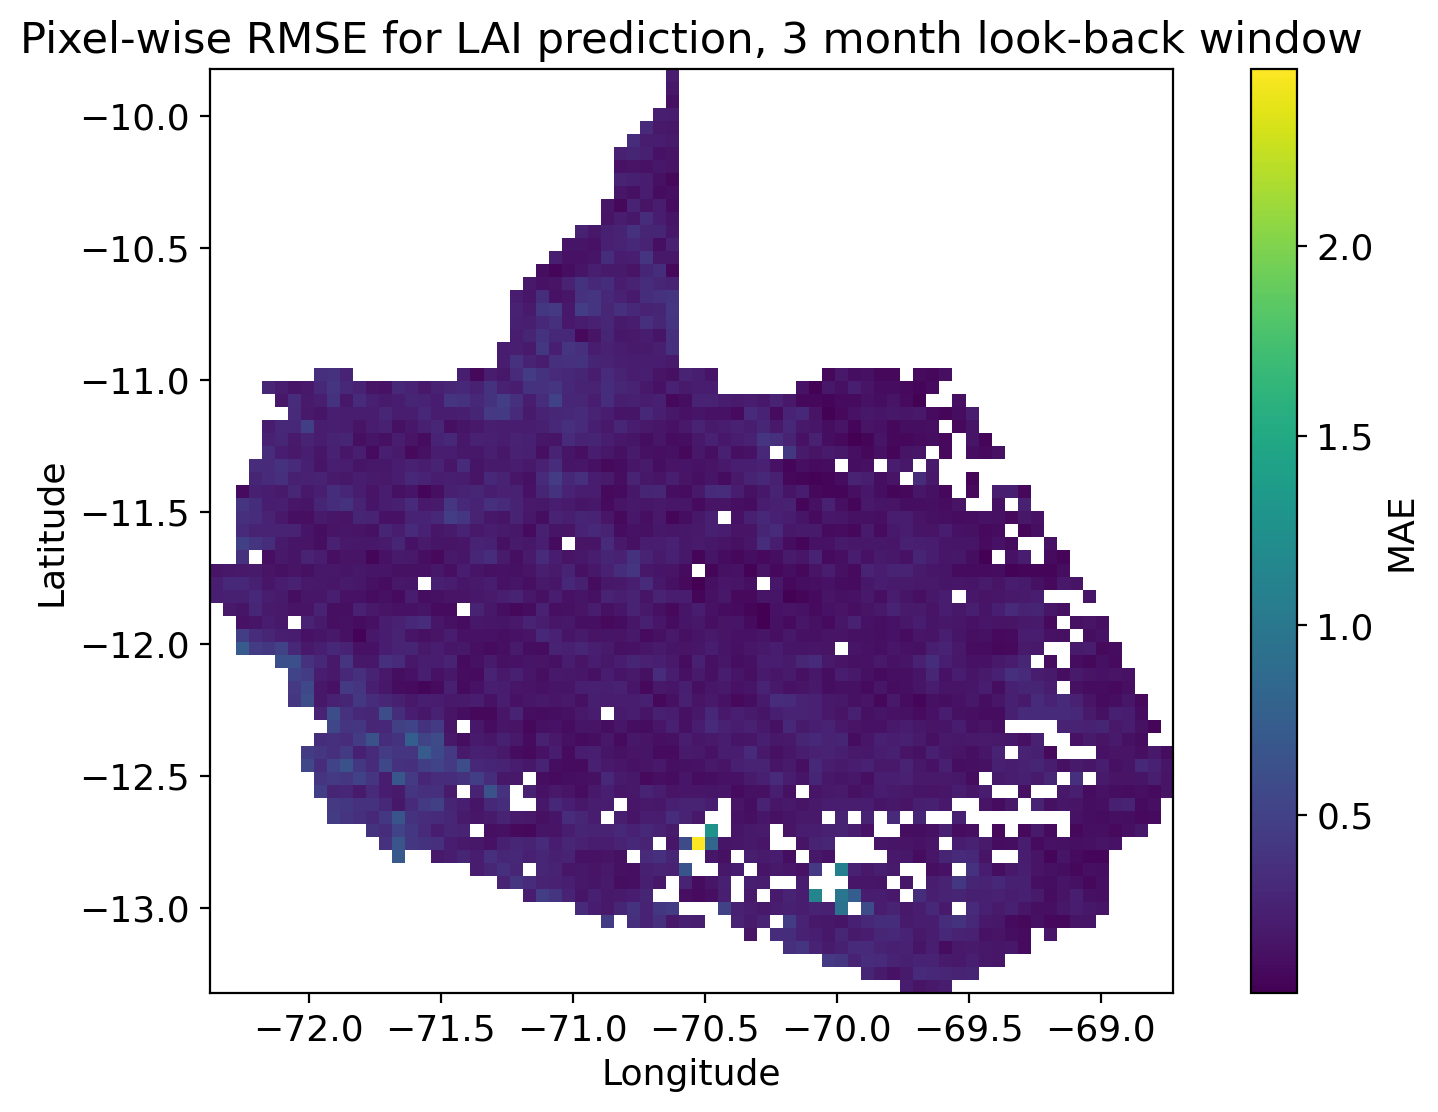

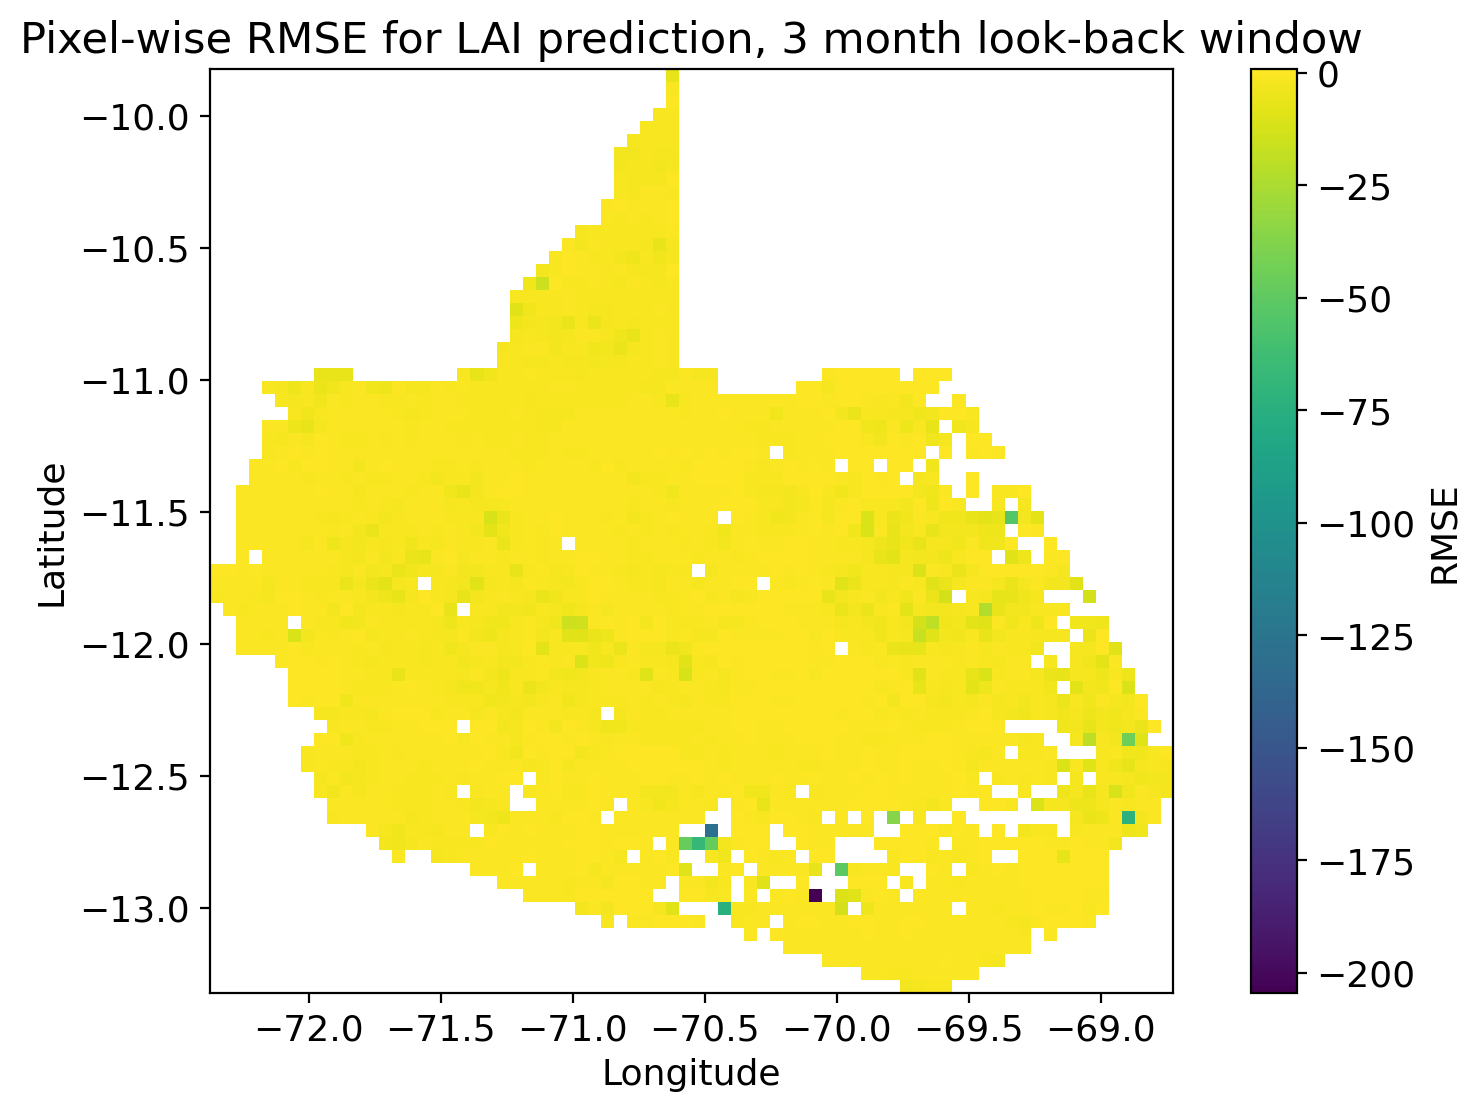

In [121]:
# plot your rmse raster
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.imshow(rmse_raster, cmap="viridis", origin="upper",
           extent=[min(lons), max(lons), min(lats), max(lats)])
plt.colorbar(label="RMSE")
plt.title("Pixel-wise RMSE for LAI prediction, 3 month look-back window")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

plt.figure(figsize=(10,6))
plt.imshow(mae_raster, cmap="viridis", origin="upper",
           extent=[min(lons), max(lons), min(lats), max(lats)])
plt.colorbar(label="MAE")
plt.title("Pixel-wise RMSE for LAI prediction, 3 month look-back window")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

plt.figure(figsize=(10,6))
plt.imshow(r2_raster, cmap="viridis", origin="upper",
           extent=[min(lons), max(lons), min(lats), max(lats)])
plt.colorbar(label="RMSE")
plt.title("Pixel-wise RMSE for LAI prediction, 3 month look-back window")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [48]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 5)]

# Number of features to consider at every split
max_features = ['sqrt', 'log2', None]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5,55, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15, 25]

# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 8, 12,16]

# Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 150, 200, 250, 300], 'max_features': ['sqrt', 'log2', None], 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, None], 'min_samples_split': [5, 10, 15, 25], 'min_samples_leaf': [4, 8, 12, 16], 'bootstrap': [True, False]}


In [49]:
reg0 = RandomForestRegressor(random_state=0)
# perform cross validation
rf_random0 = RandomizedSearchCV(estimator = reg0, param_distributions = random_grid, 
                                n_iter = 5, cv = 3, verbose=2, n_jobs = -1)
rf_tas = rf_random0.fit(train_lags_clean,y_train_lags_clean)

print("The best hyperparameters: \n",rf_tas.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=25, n_estimators=150; total time= 8.4min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=300; total time= 4.9min


/srv/conda/envs/notebook/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=25, n_estimators=150; total time= 7.7min
[CV] END bootstrap=True, max_depth=35, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=200; total time= 8.9min
[CV] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=25, n_estimators=250; total time= 3.6min
[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=25, n_estimators=150; total time= 8.3min
[CV] END bootstrap=True, max_depth=35, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=200; total time= 7.9min
[CV] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=25, n_estimators=250; total time= 3.8min
[CV] END bootstrap=True, max_depth=None, max_features=None, min_samples_leaf=16, min_samples_split=10, n_estimators=200; total time= 6.9min
The best hyperparameters: 
 {'n_es

In [78]:
def objective(trial):

    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [100, 200, 300]),
        "max_depth": trial.suggest_categorical("max_depth", [10, 20, 30, 40, 50, None]),
        "min_samples_split": trial.suggest_categorical("min_samples_split", [5,10,15,25]),
        "min_samples_leaf": trial.suggest_categorical("min_samples_leaf",  [4,8,12,16]),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True]),
    }

    model = RandomForestRegressor(
        **params,
        random_state=0,
        n_jobs=-1
    )

    cv_scores = cross_val_score(
        model, X_train, y_train['lai'],
        cv=3,
        scoring="neg_mean_squared_error",
        n_jobs=-1
    )

    return cv_scores.mean()  # Optuna maximizes objective

study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner()
)
study.optimize(objective, n_trials=30, n_jobs=1)   # 50 trials usually beats 500 random grid runs

print("Best params:", study.best_params)
print("Best score:", study.best_value)

[I 2025-12-16 01:56:03,716] A new study created in memory with name: no-name-3728f7c5-c143-48da-9c05-bd450f985d71
[I 2025-12-16 01:56:48,324] Trial 0 finished with value: -0.09930029355123106 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: -0.09930029355123106.
[I 2025-12-16 02:16:06,896] Trial 1 finished with value: -0.09542055709375612 and parameters: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 25, 'min_samples_leaf': 16, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: -0.09542055709375612.
[I 2025-12-16 02:18:44,033] Trial 2 finished with value: -0.09015185914189312 and parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 25, 'min_samples_leaf': 12, 'max_features': 'log2', 'bootstrap': True}. Best is trial 2 with value: -0.09015185914189312.
[I 2025-12-16 02:22:38,886] Trial 3 finished with value: -

Best params: {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}
Best score: -0.08909600776898713
